In [98]:
class MaxHeapq:
    """
    #code is taken from class session 7.1
    
    constructs the binary tree
    contais all the basic operations fro the tree: insertion, deletion, restructuring, outputing the highest value 
    """
    def __init__(self):
        self.heap = []
        self.heap_size = 0

    def left(self, i):
        """
        Input: i(int) index of the parent node
        output: int intex of the left child node
        """
        return 2 * i + 1

    def right(self, i):
        """
        Input: i(int), index of the parent node
        output: int, intex of the right child node
        """
        return 2 * i + 2

    def parent(self, i):
        """
        Input: i(int), index of the child node
        output: int, intex of the parent node
        """
        return (i - 1) // 2

    def maxk(self):
        """
        returns the highest priority node of the priority queue  
        """
        return self.heap[0]

    def heappush(self, key):
        """
        inserts priority into priority queue
        input: key (float), the priority value 
        output: None 
        """
        self.heap.append(Task('', 0, [], None,-float("inf")))
        self.increase_key(self.heap_size, key)
        self.heap_size += 1

    def increase_key(self, i, key):
        """
        Modifies the value of a key in a max priority queue
        with a higher value

        Input:
        i(int), the index of the key to be modified
        key(int), new key value
        
        Output: None
        """
        if key < self.heap[i]:
            raise ValueError('new key is smaller than the current key')
        self.heap[i] = key
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i)
            holder = self.heap[j]
            self.heap[j] = self.heap[i]
            self.heap[i] = holder
            i = j

    def heapify(self, i):
        """
        input: The index of the root node of the subtree to be heapified
        output: None 
        This function should modify heap in-place.
        """
        largest = i
        l = self.left(i)
        r = self.right(i)
        heap = self.heap
        if l <= (self.heap_size - 1) and heap[l] > heap[i]:
            largest = l
        if r <= (self.heap_size - 1) and heap[r] > heap[largest]:
            largest = r
        if largest != i:
            heap[i], heap[largest] = heap[largest], heap[i]
            self.heapify(largest)

    def heappop(self):
        """
        returns the larest priority element in the max priority queue
        and removes it from the queue
        
        Input: None
        Output: int, the max value in the heap that is extracted
        """
        if self.heap_size < 1:
            raise ValueError('Heap underflow: There are no keys in the priority queue ')
        maxk = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.heap_size -= 1
        self.heapify(0)
        return maxk



class Task:
    """
    #basis for code is taken from class session 7.2
    contains task attributes and function for priority update 
    
    id: unique identifier, assigned automatically 
    priority: default 0 
    describtion: string 
    duration: int, in min
    dependencies: list with task objects 
    time_constraints: list with start and end times, time frame for task to be executed. 
    status: all tasks by default are not started
    
    """
    total_number_of_tasks = 0 #task counter 
    
    def __init__(self, description, duration, dependencies, time_constraints, priority = 0):
        self.id = Task.total_number_of_tasks 
        Task.total_number_of_tasks += 1
        self.priority = priority
        self.description = description
        self.duration = duration
        self.dependencies = dependencies 
        self.time_constraints = time_constraints 
        self.status = TaskScheduler.NOT_STARTED

    def update_priority(self, current_time):
        """
        updates priority based on the attibutes of the task(time constraint, dependencies, duration) 
        
        input: int, current_time in min, task object 
        output: float, updated priority of the inputed task
        """
        if self.time_constraints: 
            #check if within the time range 
            if self.time_constraints[0] <= current_time <= (self.time_constraints[1] - self.duration):
                #substract duration to get the deadline for starting execution
                m = self.slope(self.time_constraints[0], (self.time_constraints[1] - self.duration), self.priority) 
                b = self.intersection(m, (self.time_constraints[1] - self.duration))  
                self.priority = current_time * m + b #linear function formula 
                
        if self.dependencies: 
            #manipulate the priorities for the tasks that block the given
            for i in self.dependencies: 
                i.priority += 2**len(self.dependencies)   
        
        if (not self.dependencies) and (not self.time_constraints):
            self.priority = self.duration/6 
            
    #build in functnions to compare greater/less than
    def __lt__(self, other):  
        return self.priority < other.priority

    def __gt__(self, other):
        return self.priority > other.priority

    #functinos to calculate linear equations for tasks with priorities 
    def slope(self, t1, t2, p1):
        return (100 - p1) / (t2 - t1)

    def intersection(self, slope, t2):
        return 100 - (slope * t2)


class TaskScheduler:
    """
    #basis for code is taken from class session 7.2
    
    Uses heap as the basis for its priority queue 
    pushes tasks to the priority queue and executes highest priority task one at a time 
    deletes task from the queue after execution 
    
    input: list of task objects 
    output: list of strings, describtions of the tasks in the order of execution
    
    """
    NOT_STARTED = 'N'  
    IN_PRIORITY_QUEUE = 'I'
    COMPLETED = 'C'

    def __init__(self, tasks, print_output = True):
        self.tasks = tasks
        self.print_output = print_output #turns off print statements 
        self.priority_queue = MaxHeapq()
        self.completed_tasks = []

    def calculate_priorities(self, current_time):  
        """
        updates priorities of all tasks 
        restructures binary tree based on the updated priority values 
        
        input: int, current time in min 
        output: None
        """
        for task in self.tasks: 
            task.update_priority(current_time) 
        self.priority_queue.heapify(0)

    def remove_dependency(self, task):
        """
        removes the input task all the dependencies lists it was in 
        unblocks the tasks that are dependent on the input

        input: task object 
        output: None 
        """
        for t in self.tasks:
            if task in t.dependencies: 
                t.dependencies.remove(task)

    def get_tasks_ready(self):
        """
        push tasks in the priority queue is they satisfy the requirements: 
        - not in queue yet
        - not blocked by dependencies 
        
        Input: None
        Output: None
        """
        for task in self.tasks:
            if task.status == self.NOT_STARTED and not task.dependencies: 
                task.status = self.IN_PRIORITY_QUEUE
                self.priority_queue.heappush(task) 

    def check_unfinished_tasks(self): #can be changed if we get rig of completed tasks in the original list 
        """
        checks if there are tasks in the original list that are not completed yet
        
        Input: None
        Output: None
        """
        for task in self.tasks:
            if task.status != self.COMPLETED:
                return True
        return False

    def format_time(self, time):
        return f"{time // 60}h{time % 60:02d}" 

    def run(self, starting_time):
        """
        runs the program until there are tasks that are not completed
        recalculates priorities, forms the priority queue and executes the task with the highest priority 
        removes dependecy and deletes the executed task from the queue 
        
        Input: int, starting_time in min 
        Output: list of descriptions (str) of completed tasks in order of execution 
        """
        current_time = starting_time
        if self.print_output: print("Running a simple scheduler:\n")
        
        while self.check_unfinished_tasks(): 
            self.calculate_priorities(current_time) #recalculate priorities 
            self.get_tasks_ready() #push eligible tasks in the queue 
            if self.priority_queue.heap_size:  
                task = self.priority_queue.maxk()  #execute task with the highest priority 
                if self.print_output:
                    print(f"🕰t={self.format_time(current_time)}")
                    print(f"\tstarted '{task.description}' with priority {round(task.priority,0)}")                
                    print(f"\t✅ t={self.format_time(current_time)}, task completed!")
                current_time += task.duration
                self.remove_dependency(task)  #remove task from dependencies 
                self.priority_queue.heappop() #remove task from queue
                self.completed_tasks.append(task.description)
                task.status = self.COMPLETED
                
        
        total_time = current_time - starting_time
        if self.print_output: print(f"\n🏁 Completed all planned tasks in {total_time // 60}h{total_time % 60:02d}min!")
        
        return  self.completed_tasks


task_0 = Task('Do pre-class work for CS 110', 150, [], None) 
task_1 = Task('Go for a run', 60, [], [7*60, 10*60])
task_2 = Task('Get a lunch at a traditional breakfast place', 60, [], [11*60,15*60])
task_3 = Task('Fill in the transportation card', 5, [], None)
task_4 = Task('Do stretching', 30, [task_1], None) 
task_5 = Task('Do pre-class work for CS 111', 120, [task_0], None)
task_6 = Task('Go to a temple', 90, [task_0, task_3, task_5], [9*60, 21*60])
task_7 = Task('Get Boba tea and take a break', 40, [task_0, task_5, task_6], None)

my_tasks = [task_0, task_1, task_2, task_3, task_4, task_5, task_6, task_7]


schedule = TaskScheduler(my_tasks) #I have to add at least 3 test cases
schedule.run(6 * 60) 


Running a simple scheduler:

🕰t=6h00
	started 'Do pre-class work for CS 110' with priority 1732.0
	✅ t=6h00, task completed!
🕰t=8h30
	started 'Go for a run' with priority 1355.0
	✅ t=8h30, task completed!
🕰t=9h30
	started 'Do pre-class work for CS 111' with priority 1044.0
	✅ t=9h30, task completed!
🕰t=11h30
	started 'Fill in the transportation card' with priority 1025.0
	✅ t=11h30, task completed!
🕰t=11h35
	started 'Go to a temple' with priority 2602.0
	✅ t=11h35, task completed!
🕰t=13h05
	started 'Get a lunch at a traditional breakfast place' with priority 79.0
	✅ t=13h05, task completed!
🕰t=14h05
	started 'Get Boba tea and take a break' with priority 7.0
	✅ t=14h05, task completed!
🕰t=14h45
	started 'Do stretching' with priority 5.0
	✅ t=14h45, task completed!

🏁 Completed all planned tasks in 9h15min!


['Do pre-class work for CS 110',
 'Go for a run',
 'Do pre-class work for CS 111',
 'Fill in the transportation card',
 'Go to a temple',
 'Get a lunch at a traditional breakfast place',
 'Get Boba tea and take a break',
 'Do stretching']

In [5]:
import random 
my_tasks = [task_0, task_1, task_2, task_3, task_4, task_5, task_6, task_7]

#original schedule
schedule1 = TaskScheduler(my_tasks,0) 

#2 shuffled schedules
random.shuffle(my_tasks)
schedule2 = TaskScheduler(my_tasks,0) 

random.shuffle(my_tasks)
schedule3 = TaskScheduler(my_tasks,0)

assert schedule1.run(6 * 60) == schedule2.run(6 * 60) == schedule3.run(6 * 60)

In [99]:
from time import process_time #library to mesure time
import matplotlib.pyplot as plt


"""
the following code computes the running time 
it produces the list with running time as the input increases from 5 to n
"""

heap_time = []
n = 1000
for i in range(5,n):
    start,stop = 0,0
    test_tasks = [Task('',0,[],None)] #set the first element for first random choice to work

    for t in range(i): 
        start = random.randint(6*60,21*60) 
        duration = random.randrange(1,300)
        end = start + duration + random.randint(1,2*60) #add random time to "start" but ensure it's larger than duration
        p = random.randrange(0,100)
        test_tasks.append(Task(f'Task {i}', duration, [random.choice(test_tasks)] if p > 0.5 else [], [start,end] if p > 0.7 else None ))

    start = process_time()#start timing 
    schedule = TaskScheduler(test_tasks,0) 
    schedule.run(6 * 60)
    stop = process_time()#stop timing

    heap_time.append((stop-start)*1000)#conver from sec to millisec
    

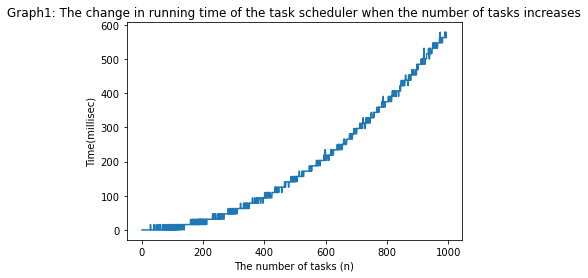

In [100]:
plt.plot(range(n-5),heap_time) 
plt.title('Graph1: The change in running time of the task scheduler when the number of tasks increases')
plt.xlabel('The number of tasks (n)')
plt.ylabel('Time(millisec)')
plt.show()

In [83]:
class MaxHeap:
    """
    #code is taken from class session 7.1
    
    constructs the binary tree
    contais all the basic operations fro the tree: insertion, deletion, restructuring, outputing the highest value 
    """
    def __init__(self):
        self.heap = []
        self.heap_size = 0

    def left(self, i):
        """
        Input: i(int) index of the parent node
        output: int intex of the left child node
        """
        return 2 * i + 1

    def right(self, i):
        """
        Input: i(int), index of the parent node
        output: int, intex of the right child node
        """
        return 2 * i + 2

    def parent(self, i):
        """
        Input: i(int), index of the child node
        output: int, intex of the parent node
        """
        return (i - 1) // 2

    def maxk(self):
        """
        returns the highest priority node of the priority queue  
        """
        return self.heap[0]

    def heappush(self, key):
        """
        inserts priority into priority queue
        input: key (float), the priority value 
        output: None 
        """
        self.heap.append(-float("inf"))
        self.increase_key(self.heap_size, key)
        self.heap_size += 1

    def increase_key(self, i, key):
        """
        Modifies the value of a key in a max priority queue
        with a higher value

        Input:
        i(int), the index of the key to be modified
        key(int), new key value
        
        Output: None
        """
        if key < self.heap[i]:
            raise ValueError('new key is smaller than the current key')
        self.heap[i] = key
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i)
            holder = self.heap[j]
            self.heap[j] = self.heap[i]
            self.heap[i] = holder
            i = j

    def heapify(self, i):
        """
        input: The index of the root node of the subtree to be heapified
        output: None 
        This function should modify heap in-place.
        """
        largest = i
        l = self.left(i)
        r = self.right(i)
        heap = self.heap
        if l <= (self.heap_size - 1) and heap[l] > heap[i]:
            largest = l
        if r <= (self.heap_size - 1) and heap[r] > heap[largest]:
            largest = r
        if largest != i:
            heap[i], heap[largest] = heap[largest], heap[i]
            self.heapify(largest)

    def heappop(self):
        """
        returns the larest priority element in the max priority queue
        and removes it from the queue
        
        Input: None
        Output: int, the max value in the heap that is extracted
        """
        if self.heap_size < 1:
            raise ValueError('Heap underflow: There are no keys in the priority queue ')
        maxk = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.heap_size -= 1
        self.heapify(0)
        return maxk

In [91]:
import random 
#testing heap class code
#code for testig is taken from class session 7.2

def heap_check(A):
    """
    input array A
    output boolean value 
    
    checks if the child is smaller than parent 
    """ 
    for i in range(len(A)):
        if A[i] < A[2*i + 1] or A[i] < A[2*i + 2]: # check each children if it is smaller than parent
            return False
        else:
            return True
        
        

test_heap = MaxHeap()
t1 = [random.randrange(-100000,100000) for i in range(10000)] #test with big input of random numbers 
for i in t1: 
    test_heap.heappush(i)
    test_heap.heapify(0)
heap_check(test_heap.heap)


True

In [97]:
test_heap2 = MaxHeap()
t2 = [random.randrange(-90,90)/random.randrange(1,1000) for i in range(100)] #test with positive and neagtive floats
for i in t2: 
    test_heap2.heappush(i)
    test_heap2.heapify(0)
heap_check(test_heap2.heap)

True

In [95]:
import math

test_heap3 = MaxHeap()
#test with different math functinos
t3 = [math.sin(3859.5), math.cos(-4859),math.tan(-892),math.log2(4048),math.factorial(6),math.expm1(94),math.asinh(62)] 
for i in t1: 
    test_heap3.heappush(i)
    test_heap3.heapify(0)
heap_check(test_heap3.heap)

True